In [1]:
import sys
sys.path.append("../")

In [5]:
from field_keypoints_detection.dataset_utils import download_data, coco_to_tfrecord_converter, load_tfrecords
from config import ROBOFLOW_API_KEY

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [20]:
download_data(api_key=ROBOFLOW_API_KEY,
              target_folder="data/keypoints/coco" ,
              workspace_name='roboflow-jvuqo',
              project_name='football-field-detection-f07vi',
              project_version=12,
              dtype='coco')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-field-detection-12 in coco:: 100%|██████████| 284/284 [00:00<00:00, 872.23it/s]


In [21]:
tfrecords_path = 'data/keypoints/tfrecords'
os.makedirs(tfrecords_path, exist_ok=True)

for s in ['train', 'valid', 'test']:
    start = 'data/keypoints/coco'
    coco_to_tfrecord_converter(f'{start}/{s}/_annotations.coco.json', f'{start}/{s}', f'{tfrecords_path}/{s}.tfrecord')

{'football-field-detection': 0, 'pitch': 1}
TFRecord file saved at data/keypoints/tfrecords/train.tfrecord
{'football-field-detection': 0, 'pitch': 1}
TFRecord file saved at data/keypoints/tfrecords/valid.tfrecord
{'football-field-detection': 0, 'pitch': 1}
TFRecord file saved at data/keypoints/tfrecords/test.tfrecord


In [32]:
train_dataset = load_tfrecords("data/keypoints/tfrecords/train.tfrecord") 
val_dataset = load_tfrecords("data/keypoints/tfrecords/valid.tfrecord")
test_dataset = load_tfrecords("data/keypoints/tfrecords/test.tfrecord") 

# Plotting Data Example

In [36]:
def plot_examples(parsed_and_decoded_dataset, num_examples=1):

  for image, keypoints in parsed_and_decoded_dataset.take(num_examples):
    plt.figure(figsize=(12,7))
    plt.imshow(image.numpy())
    plt.axis(False)


    # Reshape the keypoints array to have shape (num_keypoints, 3)
    keypoints = keypoints.numpy()
    keypoints = keypoints.reshape(-1, 3)

    for i, keypoint in enumerate(keypoints):
      x, y, visibility = keypoint
      if visibility == 2:  # Only plot visible keypoints
        plt.scatter(x, y, s=50, c='red', marker='o')
        plt.text(x, y, str(i), fontsize=12, color='blue', ha='right', va='bottom')


    plt.show()

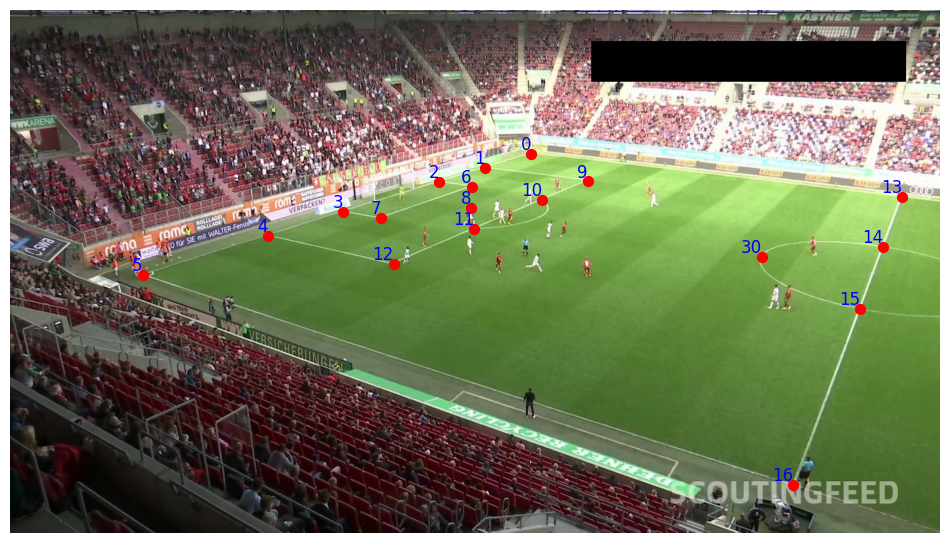

In [37]:
plot_examples(train_dataset)

# Calculating the Visibility of Each Keypoint

In [38]:
def calculate_visibility(dataset):
    keypoint_visibility_count = [0] * 32  # Assuming 32 keypoints
    total_examples = 0

    for image, keypoints in dataset:
        keypoints = keypoints.numpy().reshape(-1, 3)  # Reshape to (num_keypoints, 3)
        for i, keypoint in enumerate(keypoints):
            if keypoint[2] == 2:  # Visibility indicator
                keypoint_visibility_count[i] += 1
        total_examples += 1

    visibility_percentage = [(count / total_examples) * 100 for count in keypoint_visibility_count]
    return visibility_percentage

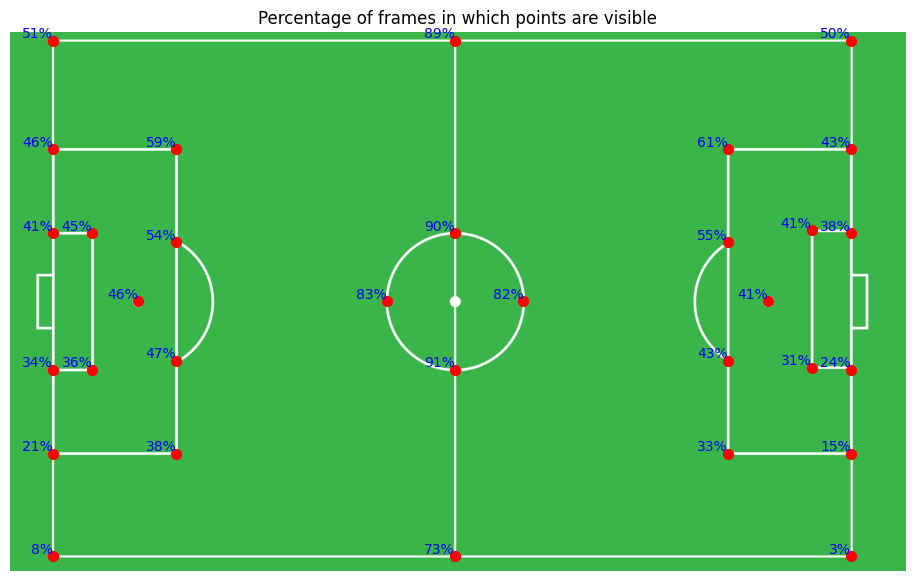

In [40]:
all_dataset = train_dataset.concatenate(val_dataset).concatenate(test_dataset)
visibility_percentage = calculate_visibility(all_dataset)

top_down_keypoints = np.array([
  [98, 19], [98, 268], [98, 460], [98, 773], [98, 964], [98, 1199], # 0-5
  [188, 460], [188, 773], # 6-7
  [292, 616], # 8
  [380, 268], [380, 481], [380, 752], [380, 964], # 9-12
  [1017, 19], [1017, 460], [1017, 773], [1017, 1199], # 13-16
  [1641, 268], [1641, 481], [1641, 752], [1641, 964], # 17-20
  [1733, 616], # 21
  [1833, 453], [1833, 767], # 22-23
  [1923, 19], [1923, 268], [1923, 460], [1923, 773], [1923, 964], [1923, 1199], # 24-29
  [861, 616], [1174, 616] # 30-31
])

template = cv2.imread('data/2d_football_pitch.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,7))
plt.title("Percentage of frames in which points are visible")
plt.axis(False)
plt.imshow(template)

for i, percentage in enumerate(visibility_percentage):
  plt.scatter(top_down_keypoints[i][0], top_down_keypoints[i][1], s=50, c='red', marker='o')
  plt.text(top_down_keypoints[i][0], top_down_keypoints[i][1], f'{round(percentage)}%', fontsize=10, color='blue', ha='right', va='bottom')

plt.savefig('../output_videos/percentage_of_visible_frames_for_each_point.png')
plt.show()